In [1]:
import pandas as pd
import numpy as np
from bff_processor.Systogram import Systogram
from bff_processor.bff_meta import *
from bff_processor.sig_op_func import *
from bff_processor.bff_cuts import bff_1, bff_2, reg_filter
from bff_processor.plotting_utils import unc_plot, boost2unc
from bff_processor.utils import nratio_plot_template, hist2unc, vunc2nom, chiSquared, color_map, quad, linear, constant
import os
import re
from time import perf_counter
import boost_histogram as bh
import pyarrow.feather as feather
import zfit
from zfit import z
from math import pi
import mplhep as hep
hep.style.use(hep.style.CMS)
plt.rcParams.update({
    "text.usetex": True,
})
from zfit.models.physics import DoubleCB
from scipy.optimize import curve_fit
from zfit.models.physics import double_crystalball_func

from bff_plotting_tools.make_hists import make_hist
from bff_plotting_tools.data_getter import get_data
from bff_signal_model.bff_signal_model import bff_signal_model, reset_params, mu

/home/ryan/Develop/Physics/env/lib/python3.8/site-packages/zfit/__init__.py:37: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."
2021-09-01 14:42:28.982664: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pickle

In [4]:
x_range = [110,800]
obs = zfit.Space("x", limits=x_range)

In [5]:
era = '2016'
df, lumi = get_data(era)
compute_hesse=True

In [6]:
from bff_signal_model.utils import get_unique_masses, make_plot_dict, make_stack_plot, compute_bin_centers

In [7]:
masses = get_unique_masses(df)
#masses = np.array([350])
plot_dict,plot_dict_centered, param_list = make_plot_dict(df, obs, masses, compute_hesse=compute_hesse)

/home/ryan/Develop/Physics/bff_plotting_code_v3/bff_signal_model/utils.py:25: UserWarning: The function <function Space.limit1d at 0x7fe0c0f60c10> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[110.]]), array([[800.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  x_range = obs.limit1d


125.0


/home/ryan/Develop/Physics/bff_plotting_code_v3/bff_signal_model/bff_signal_model.py:48: UserWarning: The function <function Space.area at 0x7fe0c0f609d0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=(0,), limits=(array([[110.]]), array([[800.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  if area == 0: area = self.norm_range.area()


150.0
175.0
200.0
350.0
500.0
125.0
150.0
175.0
200.0
350.0
500.0


In [8]:
pdf = pd.DataFrame(param_list)
pdf['fitted mass'] = pdf.mu/.995 - 0.57839198
pdf

,reg,mass,mu,mu_error,fitted mass
0,SR1,125.0,125.021510,0.000700,125.071366
1,SR1,150.0,149.897327,0.000544,150.072188
2,SR1,175.0,174.765675,0.000588,175.065502
3,SR1,200.0,199.727921,0.000519,200.153187
4,SR1,350.0,349.084519,0.001282,350.260320
5,SR1,500.0,498.411681,0.002579,500.337870
6,SR2,125.0,124.930788,0.001209,124.980189
7,SR2,150.0,149.880529,0.001168,150.055306
8,SR2,175.0,174.737909,0.001414,175.037597
9,SR2,200.0,199.646988,0.001141,200.071847


In [9]:
if compute_hesse: pdf.to_csv('fits/bff/bff_mass_only_model_fit_{}.csv'.format(era))

[]
[]


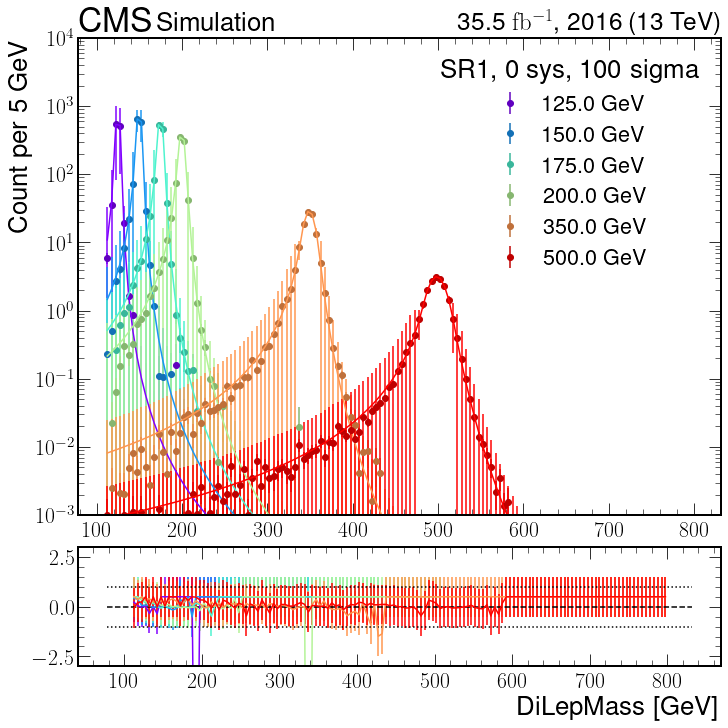

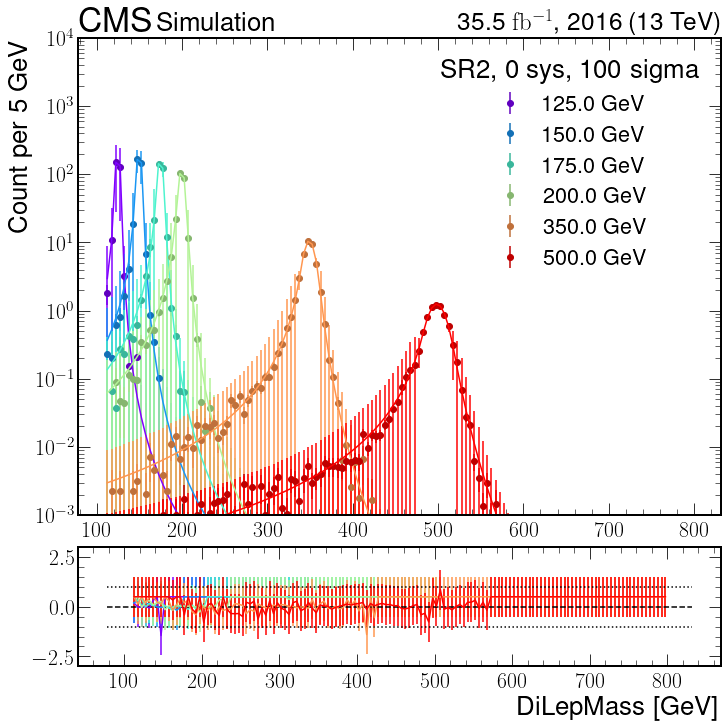

In [10]:
_ = make_stack_plot(plot_dict, masses, pdf, lumi, era, compute_hesse, yscale='log')

In [11]:
pdf

,reg,mass,mu,mu_error,fitted mass,chi2
0,SR1,125.0,125.021510,0.000700,125.071366,0.233028
1,SR1,150.0,149.897327,0.000544,150.072188,0.189788
2,SR1,175.0,174.765675,0.000588,175.065502,0.181064
3,SR1,200.0,199.727921,0.000519,200.153187,0.188695
4,SR1,350.0,349.084519,0.001282,350.260320,0.172166
5,SR1,500.0,498.411681,0.002579,500.337870,0.111549
6,SR2,125.0,124.930788,0.001209,124.980189,0.220256
7,SR2,150.0,149.880529,0.001168,150.055306,0.190900
8,SR2,175.0,174.737909,0.001414,175.037597,0.190251
9,SR2,200.0,199.646988,0.001141,200.071847,0.186986


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


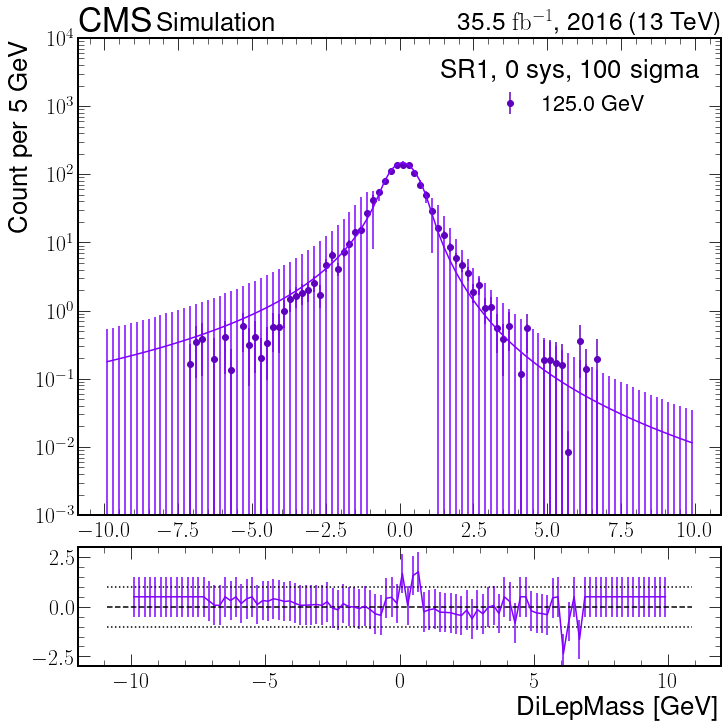

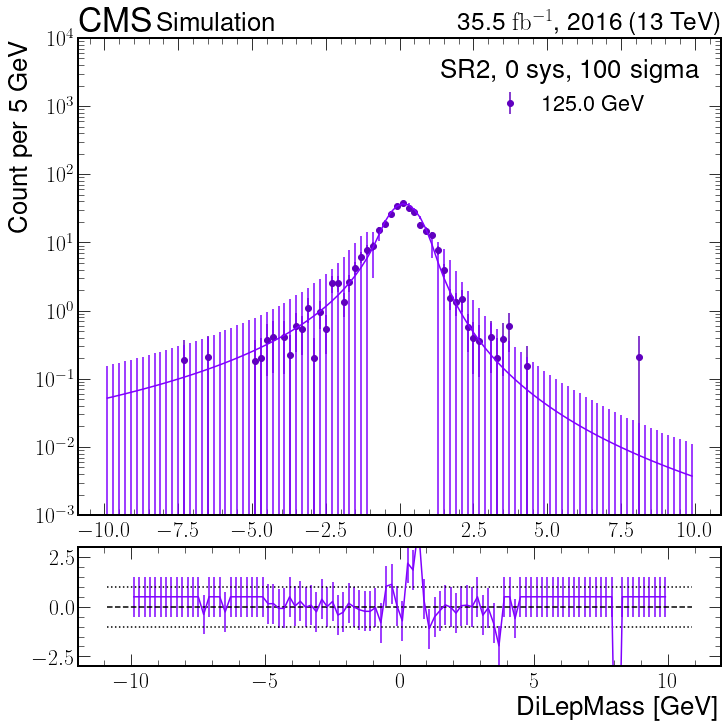

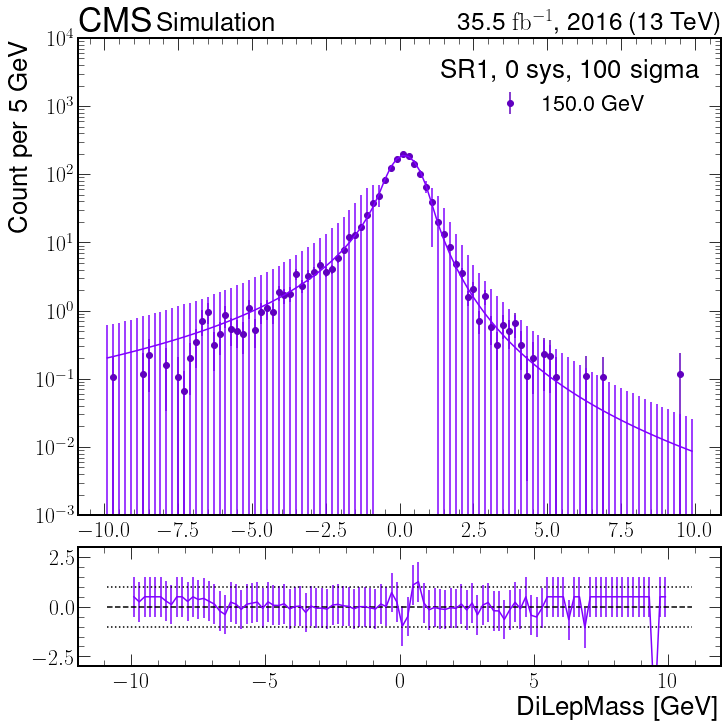

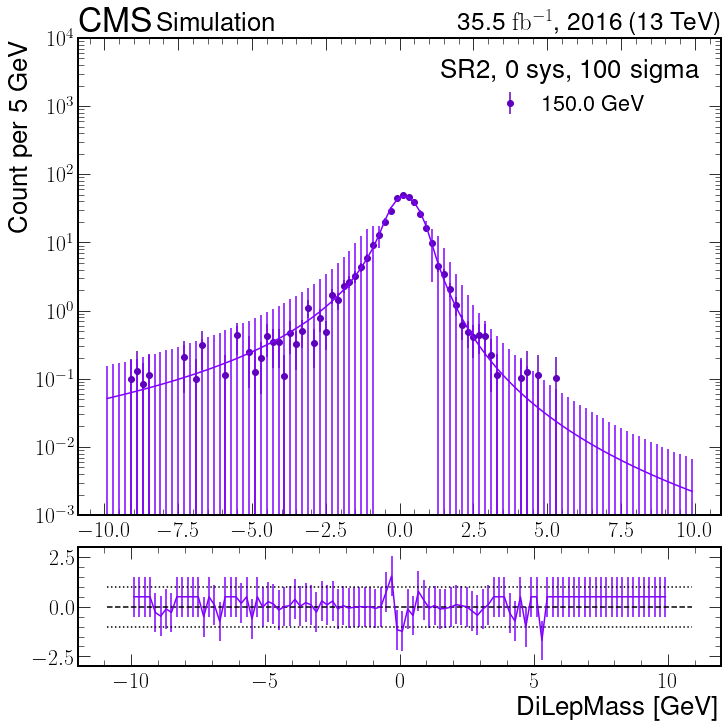

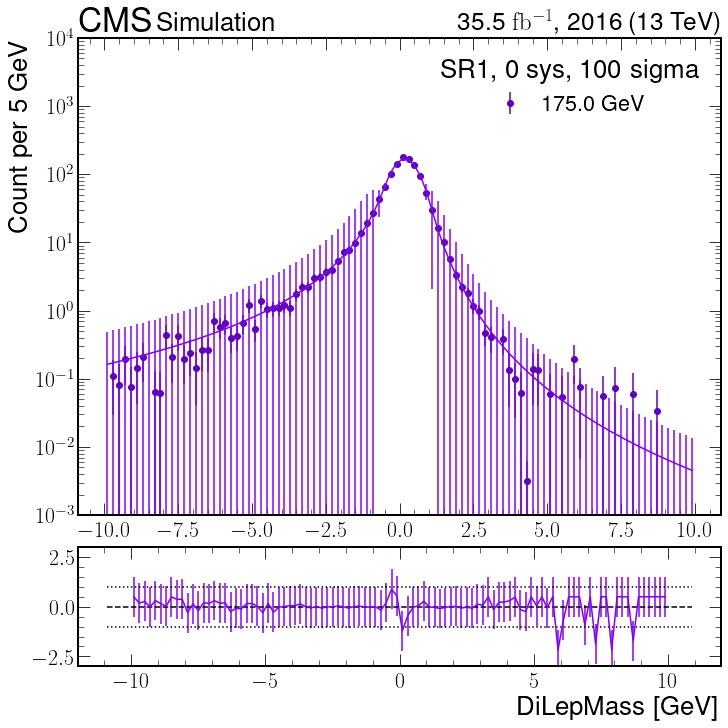

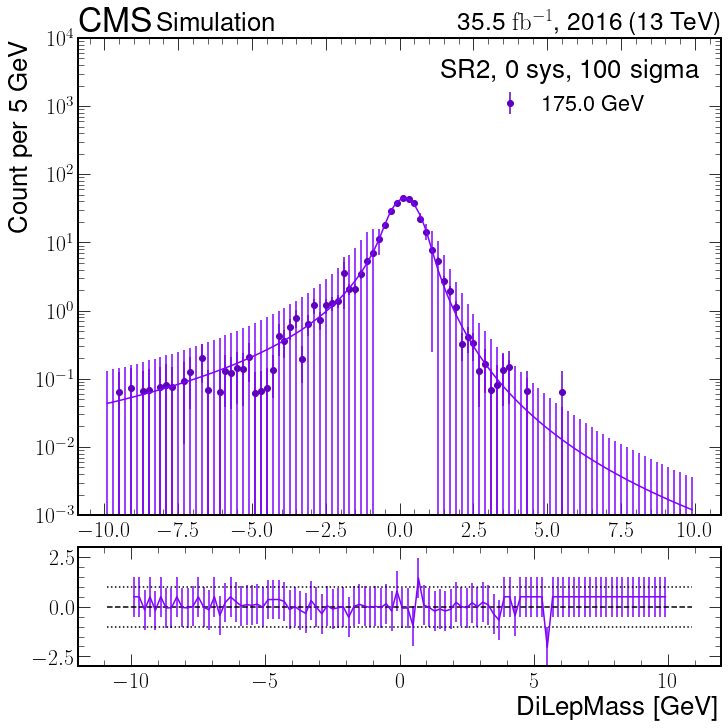

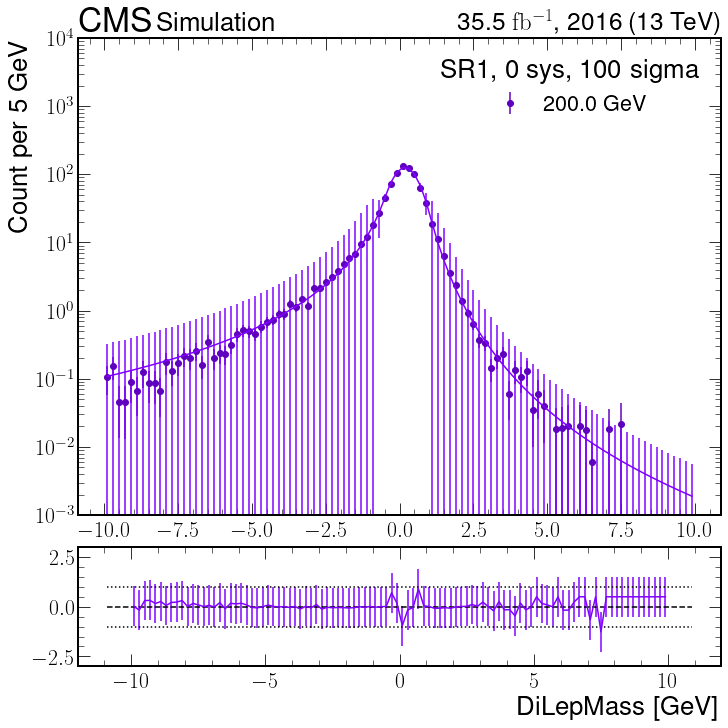

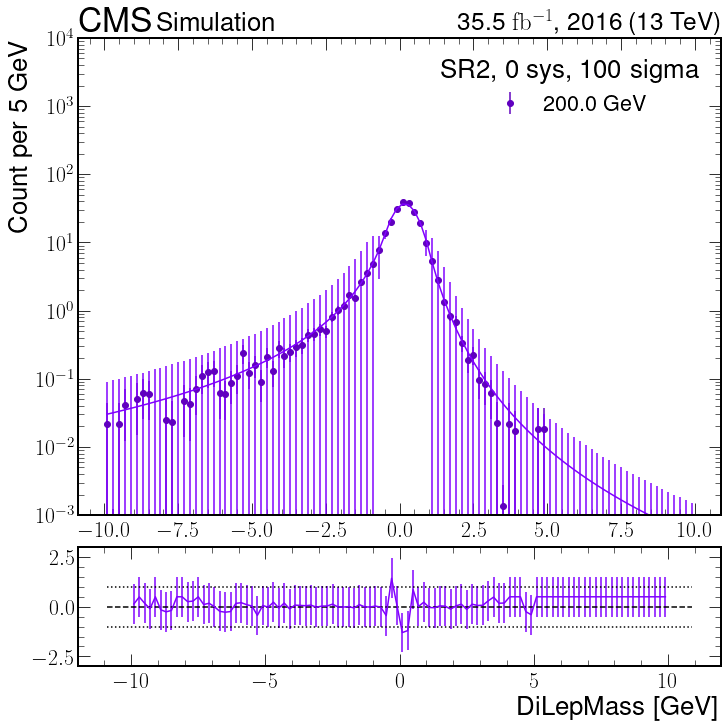

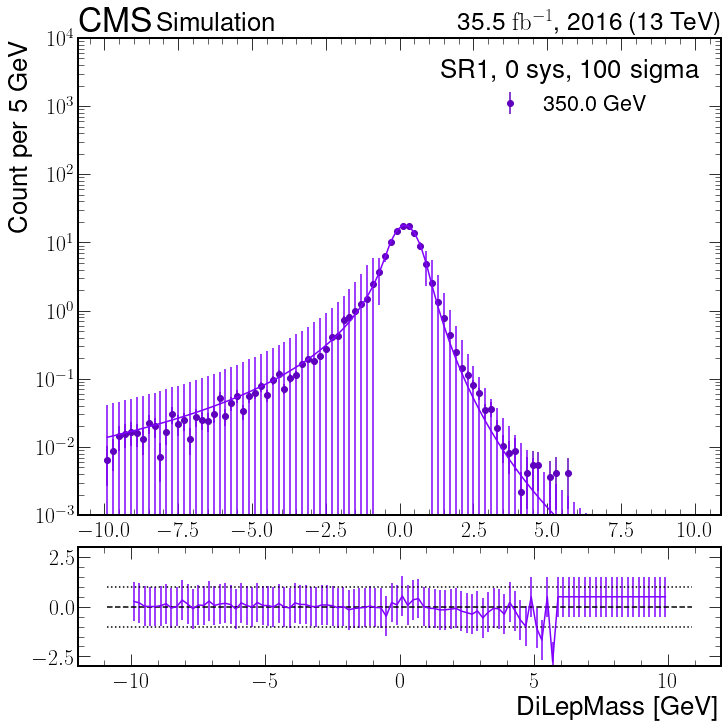

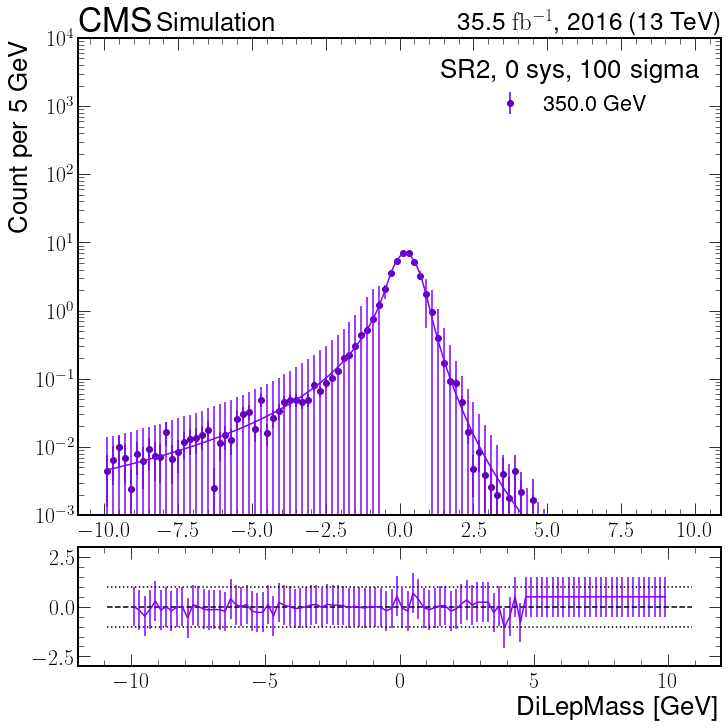

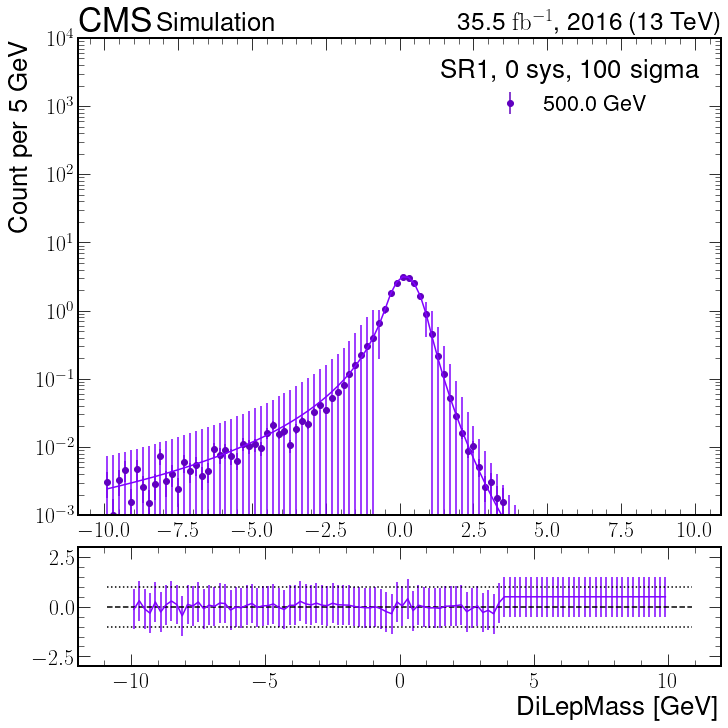

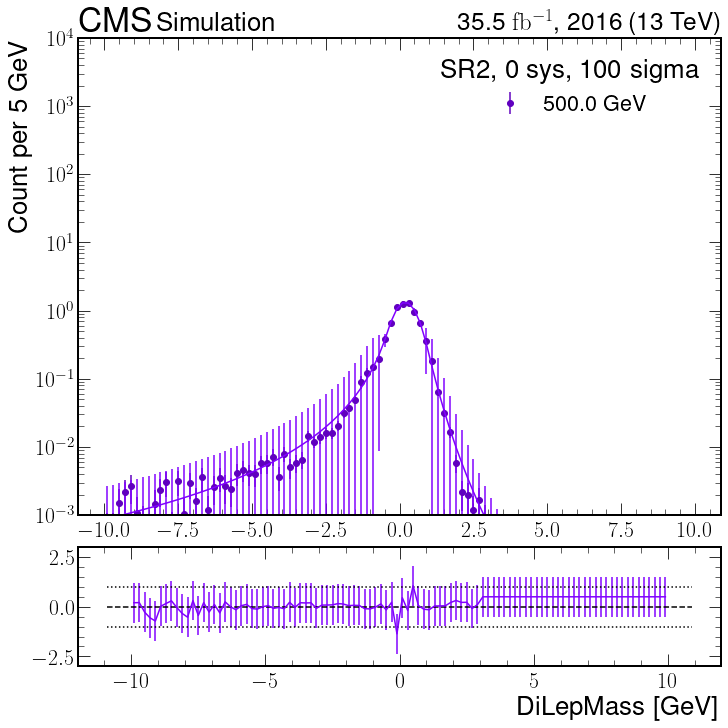

In [12]:
for mass in masses:
    make_stack_plot(plot_dict_centered, [mass], pdf, lumi, era, compute_hesse,postfix="_{}".format(mass))

[]
[]


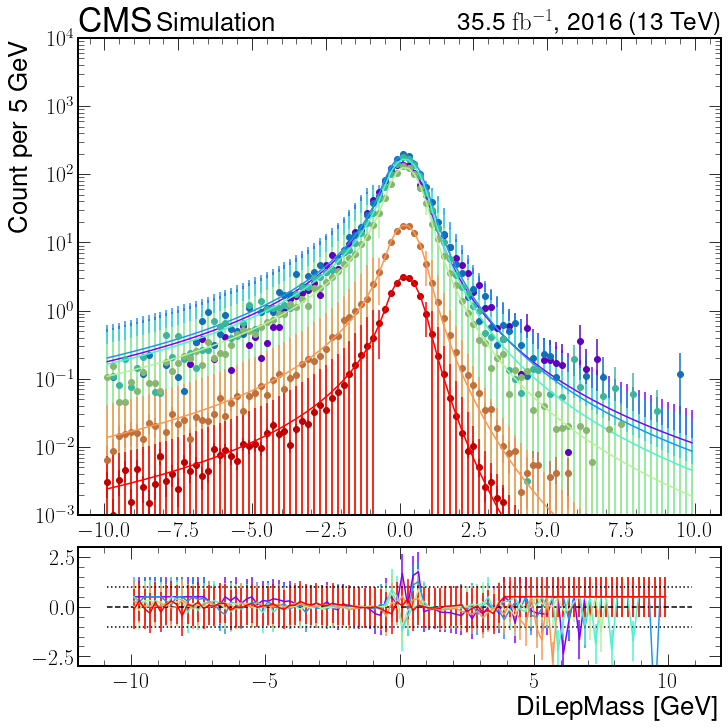

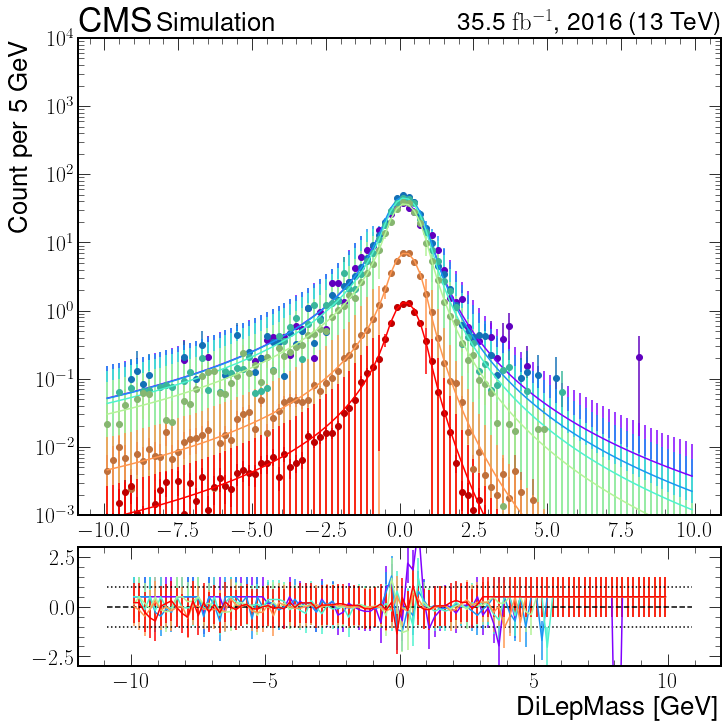

In [13]:
residual_dict = make_stack_plot(plot_dict_centered, masses, pdf, lumi, era, compute_hesse, legend=False,
                              bottom_limit=[-3,3], postfix="_centered")

In [14]:
if compute_hesse: pdf.to_csv('fits/bff/bff_mass_only_model_fit_{}.csv'.format(era))
pdf

,reg,mass,mu,mu_error,fitted mass,chi2
0,SR1,125.0,125.021510,0.000700,125.071366,0.208714
1,SR1,150.0,149.897327,0.000544,150.072188,0.145901
2,SR1,175.0,174.765675,0.000588,175.065502,0.131164
3,SR1,200.0,199.727921,0.000519,200.153187,0.083831
4,SR1,350.0,349.084519,0.001282,350.260320,0.118152
5,SR1,500.0,498.411681,0.002579,500.337870,0.097184
6,SR2,125.0,124.930788,0.001209,124.980189,0.277301
7,SR2,150.0,149.880529,0.001168,150.055306,0.172723
8,SR2,175.0,174.737909,0.001414,175.037597,0.144155
9,SR2,200.0,199.646988,0.001141,200.071847,0.139030


In [15]:
print(pdf.round(3).to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} &  reg &   mass &       mu &  mu\_error &  fitted mass &   chi2 \\
\midrule
0  &  SR1 &  125.0 &  125.022 &     0.001 &      125.071 &  0.209 \\
1  &  SR1 &  150.0 &  149.897 &     0.001 &      150.072 &  0.146 \\
2  &  SR1 &  175.0 &  174.766 &     0.001 &      175.066 &  0.131 \\
3  &  SR1 &  200.0 &  199.728 &     0.001 &      200.153 &  0.084 \\
4  &  SR1 &  350.0 &  349.085 &     0.001 &      350.260 &  0.118 \\
5  &  SR1 &  500.0 &  498.412 &     0.003 &      500.338 &  0.097 \\
6  &  SR2 &  125.0 &  124.931 &     0.001 &      124.980 &  0.277 \\
7  &  SR2 &  150.0 &  149.881 &     0.001 &      150.055 &  0.173 \\
8  &  SR2 &  175.0 &  174.738 &     0.001 &      175.038 &  0.144 \\
9  &  SR2 &  200.0 &  199.647 &     0.001 &      200.072 &  0.139 \\
10 &  SR2 &  350.0 &  349.066 &     0.003 &      350.242 &  0.108 \\
11 &  SR2 &  500.0 &  498.432 &     0.007 &      500.358 &  0.136 \\
\bottomrule
\end{tabular}



In [ ]:
for reg, reg_dict in plot_dict_centered.items():
    for mass, mass_dict in reg_dict.items():
        print(mass, reg)
        print(mass_dict.keys())
        fit = mass_dict['fit']
        hist = mass_dict['hist']
        hist_std = mass_dict['hist_std']
        bins = mass_dict['bins']
        bin_centers = compute_bin_centers(bins)
        residual = abs(fit-hist)/(hist_std+.1)
        plt.plot(bin_centers, residual)
        plt.show()

In [ ]:
colors = color_map(len(masses))
bin_centers_centered = [(bins_centered_peak[i]+bins_centered_peak[i+1])/2 for i in range(len(bins_centered_peak) - 1)]
for reg, reg_dict in plot_dict.items():
    fig, ax = nratio_plot_template(nPlots=[1,1])
    (top, bottom) = ax[0][0]
    for color, (mass, mass_dict) in zip(colors,reg_dict.items()):
        #make a different color for histogram
        hist_color = np.power(color, 1)*.75
        #set alpha
        hist_color[-1] = 1

        fit_plot = mass_dict['fit_width_norm']
        hist = mass_dict['hist_width_norm']
        hist_std = mass_dict['hist_std_width_norm']

        
        # remove low content bins:
        total = np.sum(fit_plot)
        width = 100
        max_bin, min_bin = mass+sigma_from_mass(mass)*width,mass-sigma_from_mass(mass)*width
        filter_array =np.logical_and(bin_centers_centered < max_bin, bin_centers_centered > min_bin)
        hist = hist[filter_array]
        systematics=0
        hist_std = ((hist_std[filter_array] ** 2) + (hist*systematics ** 2)) ** .5
        bin_centers_centered_temp =np.array(bin_centers_centered)[filter_array]
        fit_plot = fit_plot[filter_array]
        
        #fit_plot *= np.sum(hist)/np.sum(fit_plot)
        top.errorbar(bin_centers_centered_temp, hist, yerr = hist_std, label='{} GeV'.format( mass), color=hist_color, linestyle="None")
        top.plot(bin_centers_centered_temp, fit_plot, color=color)
        bottom.errorbar(bin_centers_centered_temp, (fit_plot-hist)/hist_std, yerr=hist_std/hist_std, color=color)
 
        #def filter out 0 values:
        hist_filt = hist[hist!=0]
        hist_std_filt = hist_std[hist!=0]
        fit_plot_filt = fit_plot[hist!=0]
        
        pdf.loc[(pdf.mass==mass) & (pdf.reg==reg), 'chi2'] = chi2(fit_plot_filt, hist_filt, hist_std_filt, ndf=1)
        
        
        
    top.legend(title="{}, {} sys, {} sigma".format(reg, systematics, width))
    top.set_yscale('log')
    top.set_ylim(bottom=.1e-2,top=1e4)
    bottom.set_ylim(bottom=-3, top=3)
    bottom.plot(top.get_xlim(), np.full(len(top.get_xlim()), -1), color='black', linestyle=':')
    bottom.plot(top.get_xlim(), np.full(len(top.get_xlim()), 0), color='black', linestyle='--')
    bottom.plot(top.get_xlim(), np.full(len(top.get_xlim()), 1), color='black', linestyle=':')
    bottom.set_xlabel('DiLepMass [GeV]')
    top.set_ylabel('Count per 5 GeV')
    hep.cms.label(loc=0,ax=top,lumi=lumi,year=era, data=False)
#if compute_hesse:
#    fig.savefig('fits/bff/bff_mass_only_model_{}_{}.png'.format(reg, era))
#else:
#    fig.savefig('fits/bff/bff_mass_only_model_{}_{}_nohess.png'.format(era, reg))

In [ ]:
def gs_plot(xrange, yrange, **kwargs):
    fig = plt.figure(constrained_layout=True, **kwargs)
    gs = fig.add_gridspec(xrange,yrange)
    for x in range(xrange):
        for y in range(yrange):
            fig.add_subplot(gs[x,y])
    return fig

In [ ]:
from scipy.optimize import curve_fit

In [18]:
def constant(x, b):
    return linear(x, b, 0)

def linear(x, b, m):
    return m * x + b

def quad(x, b, m, m2):
    return m2 * x ** 2 + m * x + b

mu [0.54282904 0.9957671 ]
mu [0.45484298 0.99597684]


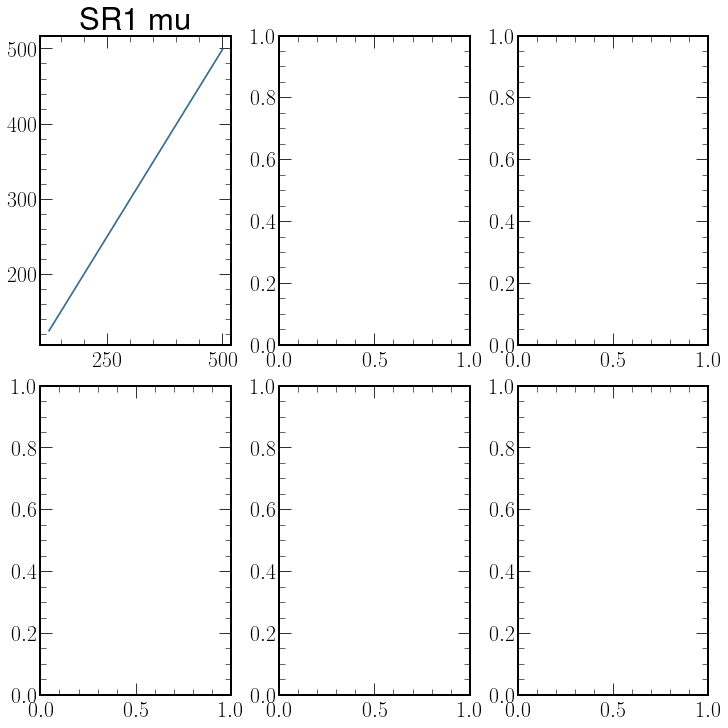

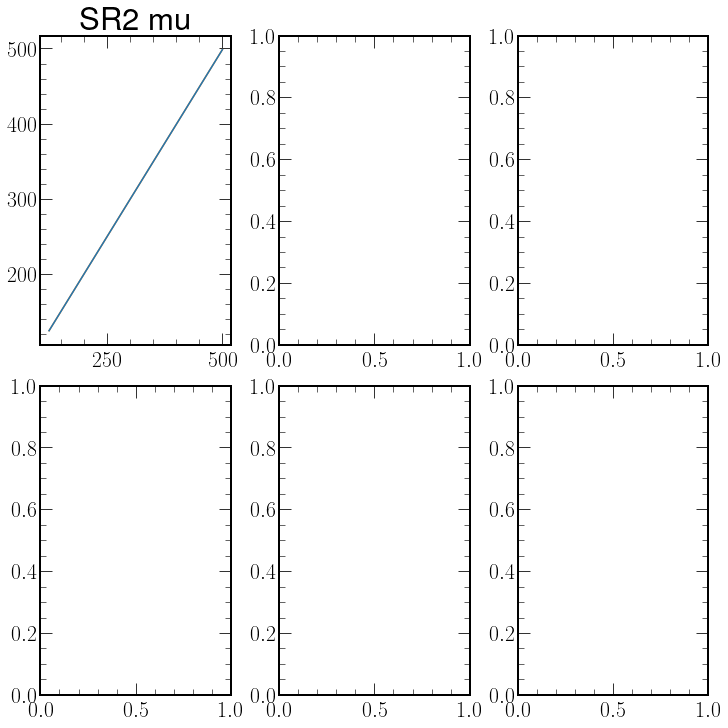

In [19]:
params = ["alphal" ,"alphar" ,"mu","nl" ,"nr" ,"sigma"]
indicies =  [2,5,0,1,4,3]
funcs =[linear,linear,linear,constant,linear,quad]
for reg in pdf.reg.unique():
    tdf = pdf[pdf.reg==reg]
    x = tdf.mass.to_numpy()
    fig = gs_plot(2,3) 
    for index, par, func in zip(indicies, params, funcs):
        axes = fig.axes[index]
        try:
            y = tdf[par].to_numpy()
        except:
            continue
        if compute_hesse:
            yerr = tdf[par+"_error"].to_numpy()
            axes.errorbar(x, y, yerr=yerr)
        else:
            axes.plot(x, y)
        axes.set_title(reg + " " + par)
        
        # best fit
        # cut left bins on left side
        if par in ['nl', 'alphal']:
            y = y[x>x_range[0]+50]
            xplot = x[x>x_range[0]+50]
        else:
            xplot = x
        popt,pcov = curve_fit(func, xplot, y)
        fit_y = func(xplot, *popt)
        axes.plot(xplot, fit_y)
        
        print(par, popt)
    if compute_hesse:
        fig.savefig('fits/bff/params_mass_only_model_{}_{}.png'.format(era, reg, par))
    else:
        fig.savefig('fits/bff/params_mass_only_model_{}_{}_nohess.png'.format(era, reg, par))

In [20]:
def make_hist(
              df, 
              axismeta, axisname, 
              weightname,
              regionname,
              typename,
              variablename,
              uniquelabels=[]
             ):

    ldf = df[(df[regionname]==1) & (df.type==typename)]
    values = ldf[variablename]
    weights = ldf[weightname]
    labels = ldf['labels']
    if uniquelabels==[]:
        uniquelabels =  np.unique(labels)
    
    dr_hist = (hist.Hist.new
               .StrCat(uniquelabels, name = "labels")
               .Reg(*axismeta, name=axisname)
               .Weight())
    
    dr_hist.fill(labels, values, weight=weights)
    return dr_hist

In [21]:
def make_type_hists(
              df, 
              axismeta, axisname, 
              weightname,
              regionname,
              variablename,
              data = 1
             ):
    uniquelabels = ['DiBoson', 'ST', 'TT', 'DY']
    typename = 'bck'
    bck_hist = make_hist(df, axismeta, axisname, weightname,regionname,typename,
                         variablename,
                         uniquelabels=uniquelabels)
    
    typename = 'sig'
    sig_hist = make_hist(df, axismeta, axisname, weightname,regionname,typename,
                        variablename,)
    
    if data:
        typename = 'data'
        data_hist = make_hist(df, axismeta, axisname, weightname,regionname,typename,
                             variablename,)
        return bck_hist, sig_hist, data_hist
    else:
        return bck_hist, sig_hist

In [22]:
def make_sys(df,  axismeta, axisname, regiontemplate, weightname, bck_hist, sig_hist, variablename,
            regionname):  
    sys_array = []
    sig_sys_array = []
    for jetcorr in ['jer', 'jesTotal']:
        cor = []
        sig_cor = []
        for direction in ['Up','Down']:
            correction = '{}{}'.format(jetcorr, direction)
            regionnamesys = regiontemplate.format(correction)
            bck_hist_corr_temp, sig_hist_corr_tem = make_type_hists( df,  axismeta, axisname,  
                                                                    weightname, regionnamesys, 
                                                                    variablename,
                                                                    data=0)
            cor.append(bck_hist_corr_temp[::sum,:].values()-bck_hist[::sum,:].values())
            sig_cor.append(sig_hist_corr_tem.values()-sig_hist.values())
            
        cor = sorted(cor, key=lambda x: np.sum(x))
        sig_cor = sorted(sig_cor, key=lambda x: np.sum(x))
        sys_array.append(cor)
        sig_sys_array.append(sig_cor)
        
    weightsys = ["Weight_Pu","Weight_BTag","Weight_PUID","Weight_PDF_ISRFSR_","Weight_MuonSF","Weight_ElectronSF"]
    for sys in weightsys:
        cor = []
        sig_cor = []
        for direction in ['Up','Down']:
            weightnamesys = sys+direction
            bck_hist_corr_temp, sig_hist_corr_tem = make_type_hists( df,  axismeta, axisname,  
                                                                    weightnamesys, regionname, 
                                                                    variablename,
                                                                    data=0)
            cor.append(bck_hist_corr_temp[::sum,:].values()-bck_hist[::sum,:].values())
            sig_cor.append(sig_hist_corr_tem.values()-sig_hist.values())
            
        cor = sorted(cor, key=lambda x: np.sum(x))
        sig_cor = sorted(sig_cor, key=lambda x: np.sum(x))
        sys_array.append(cor)
        sig_sys_array.append(sig_cor)

    down, up = np.sum(sys_array,axis=0)
    sig_down, sig_up = np.sum(sig_sys_array, axis=0)
    return down, up, sig_down, sig_up

In [23]:
def make_hist(df, column, region, bins=np.linspace(110,800, 100), weights='Weight', region_sys='nom', std=0):
        region = "{}_{}".format(region, region_sys)
        df_temp = df[df[region]==1]
        hist = np.histogram(df_temp[column],
                     bins=bins,
                     weights=df_temp[weights])[0]
        if std:
            std_hist = np.histogram(df_temp[column],
                     bins=bins,
                     weights=df_temp[weights]**2)[0]**.5
            return hist, std_hist
        return hist

In [24]:
make_hist(df, 'DiLepMass', 'SR1', region_sys='jerDown', weights='Weight_MuonSFDown', std=1)

(array([1.24444462e+01, 3.05771401e+02, 7.45108795e+02, 3.02387495e+01,
        7.79357871e+01, 9.89816870e+02, 2.27012393e+02, 4.05651413e+01,
        2.57521616e+02, 7.75860270e+02, 6.21760084e+01, 5.92820008e+01,
        4.26207239e+02, 2.69740350e+02, 1.52251577e+01, 1.72994283e+00,
        5.19870486e-01, 1.73510916e-01, 1.27611853e-01, 9.79425865e-02,
        8.56149607e-02, 9.99897498e-02, 1.01827583e-01, 1.39606031e-01,
        2.13718939e-01, 2.08688135e-01, 3.10907684e-01, 4.23969957e-01,
        6.55348488e-01, 1.26494670e+00, 2.05200467e+00, 3.57833334e+00,
        9.79702564e+00, 2.74817318e+01, 3.67735815e+01, 1.82935511e+01,
        4.60305709e+00, 1.22408198e+00, 3.68369998e-01, 1.72380855e-01,
        9.59528567e-02, 4.80369492e-02, 3.13916971e-02, 4.23025566e-02,
        4.29530656e-02, 5.82764779e-02, 6.61566417e-02, 8.20307687e-02,
        1.15922415e-01, 2.01931992e-01, 2.99836946e-01, 4.68483272e-01,
        8.30598385e-01, 1.70148889e+00, 3.04848953e+00, 4.027126

In [42]:
def make_sys(df, column, regionname, bins=np.linspace(110,800,100)): 
    nominal, std = make_hist(df, column, regionname,bins=bins, std=1)
    sys_array = []
    for jetcorr in ['jer', 'jesTotal']:
        cor = []
        sig_cor = []
        for direction in ['Up','Down']:
            reg_sys = '{}{}'.format(jetcorr, direction)
            sys_hist = make_hist(df, column, regionname, region_sys=reg_sys,bins=bins)
            cor.append(sys_hist - nominal) 
        cor = sorted(cor, key=lambda x: np.sum(x))
        sys_array.append(cor)   
    weightsys = ["Weight_Pu","Weight_BTag","Weight_PUID","Weight_PDF_ISRFSR_","Weight_MuonSF","Weight_ElectronSF"]
    for sys in weightsys:
        cor = []
        sig_cor = []
        for direction in ['Up','Down']:
            weightnamesys = sys+direction
            sys_hist = make_hist(df, column, regionname, weights=weightnamesys,bins=bins)
            cor.append(sys_hist - nominal) 
        cor = sorted(cor, key=lambda x: np.sum(x))
        sys_array.append(cor)
    down, up = np.sum(sys_array,axis=0)
    # one line to sort up/down bins
    # list(zip(*map(sorted,zip(up,down))))
    return nominal, down, up, std

In [43]:
def constant(x, b):
    return linear(x, b, 0)

def linear(x, b, m):
    return m * x + b

def quad(x, b, m, m2):
    return m2 * x ** 2 + m * x + b

def pol4(x, b, m, m2, m3):
    return m3 * x**3 + m2 * x ** 2 + m * x + b
from scipy.optimize import curve_fit

In [44]:
def make_sys_stats(mass, reg):
    bins=np.linspace(110,800,800)
    bins_center = np.array([(bins[i]+bins[i+1])/2 for i in range(len(bins[:-1]))])
    nominal, down, up, std = make_sys(df[df.mass==mass], 'DiLepMass',reg, bins=bins)
    
    down_norm =(nominal+down)/nominal
    up_norm =(nominal+up)/nominal
    std_norm = std/nominal
    
    width = 4
    max_bin, min_bin = mass+sigma_from_mass(mass)*width,mass-sigma_from_mass(mass)*width
    filter_array =np.logical_and(bins_center < max_bin, bins_center > min_bin)
    nominal = nominal[filter_array]
    std_norm = std_norm[filter_array]
    up_norm = up_norm[filter_array]
    down_norm = down_norm[filter_array]
    bins_center = bins_center[filter_array]
    
    plt.errorbar(bins_center, (nominal)/nominal, yerr=std_norm, label="{} {}".format(mass, reg))
    plt.plot(bins_center, down_norm, label='down (linear addition)')
    plt.plot(bins_center, up_norm, label=' up (linear addition)')
    plt.plot(bins_center, np.full(len(bins_center),1), linestyle='--')
    plt.plot(bins_center, np.full(len(bins_center),.7), linestyle=':')
    plt.plot(bins_center, np.full(len(bins_center),1.3), linestyle=':')
    plt.ylim(top=2, bottom=0)
    #plt.legend()
    plt.xlabel('Mass [GeV]')
    plt.ylabel('fraction of nominal')
    #plt.show()
    #plt.savefig('systematics/norm_sys_{}_{}_{}.png'.format(era, mass, reg))
    return np.average(down_norm[down_norm>0], weights=std_norm[down_norm>0])-1, np.average(up_norm[up_norm<100], weights=std_norm[up_norm<100])-1

/tmp/ipykernel_1873834/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_1873834/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_1873834/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_1873834/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.5726273197113826, 0.21844515183073665)


/tmp/ipykernel_1873834/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_1873834/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_1873834/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_1873834/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_1873834/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.5242144192385423, 0.21584333006008083)


/tmp/ipykernel_1873834/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_1873834/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_1873834/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_1873834/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_1873834/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.4954007502482106, 0.23832421220837752)


/tmp/ipykernel_1873834/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_1873834/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_1873834/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.2758447829195948, 0.2772068445575009)


/tmp/ipykernel_1873834/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_1873834/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_1873834/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_1873834/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_1873834/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.2454684415865841, 0.2561288472496759)


/tmp/ipykernel_1873834/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_1873834/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_1873834/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_1873834/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_1873834/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.23115819589209596, 0.24808957166389933)


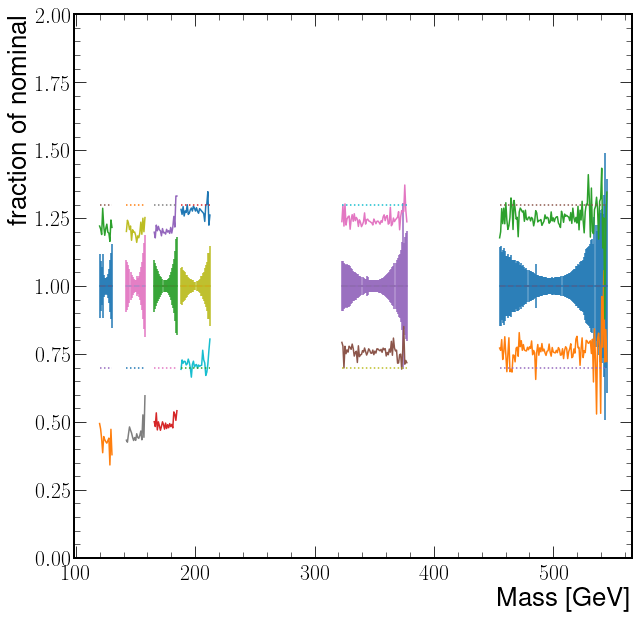

In [45]:
reg = 'SR1'
for mass in masses:
    print(make_sys_stats(mass,reg))    
plt.savefig('systematics/relative_sys_{}_{}.png'.format(era, reg))

/tmp/ipykernel_1873834/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_1873834/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_1873834/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.37169579981380285, 0.26132641897923015)


/tmp/ipykernel_1873834/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_1873834/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_1873834/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.37741743545654705, 0.31105497613563804)


/tmp/ipykernel_1873834/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_1873834/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_1873834/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_1873834/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.4717405175979339, 0.2686736707322379)


/tmp/ipykernel_1873834/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_1873834/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_1873834/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_1873834/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_1873834/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.3170428922735721, 0.27332335641054484)


/tmp/ipykernel_1873834/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_1873834/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_1873834/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_1873834/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_1873834/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.27161584897330593, 0.2908271636710711)


/tmp/ipykernel_1873834/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_1873834/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_1873834/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_1873834/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_1873834/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal
/tmp/ipykernel_1873834/344296802.py:19: RuntimeWarning: invalid value encountered in true_divide
  plt.errorbar(bins_center, (nominal)/nominal, yerr=std_norm, label="{} {}".format(mass, reg))


(-0.2529595537336441, 0.2468075749335703)


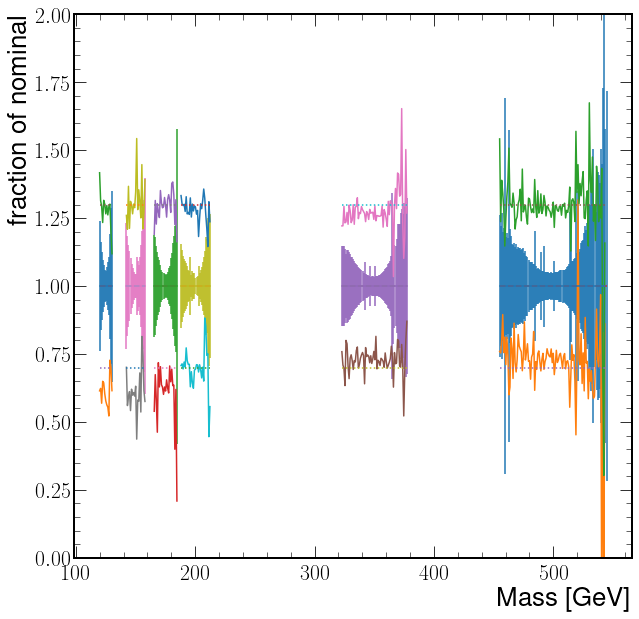

In [46]:
reg = 'SR2'
for mass in masses:
    print(make_sys_stats(mass,reg))    
plt.savefig('systematics/relative_sys_{}_{}.png'.format(era, reg))